In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import time

## Parameters

In [3]:
features = ['PE_RATIO', 'Fwd_PE_RATIO', '5Y_GENERIC', '1Y_GENERIC', 'PE_Yield', 'FWD_PE_minus_5Y', 'CPI_YOY' ,'Expected_inflation_5Y']
# features = ['PE_RATIO']
# features = ['Fwd_PE_RATIO']
# features = ['5Y_GENERIC']
# features = ['1Y_GENERIC']
# features = ['PE_Yield']
# features = ['FWD_PE_minus_5Y']
# features = ['CPI_YOY']
# features = ['Expected_inflation_5Y']

In [4]:
days_for_test = 48
target = 'S&P_500_FORWARD_1_YEAR_GAIN'

# The yearly forward change in S&P 500 for classification (in %)
decline = -0.1
increase = 1

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 7)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

## Open the data

In [5]:
df = pd.read_csv(r'C:\Users\User\Documents\GitHub\Investment_5Y_and_s&p500_yield_spread\data.csv')

In [6]:
this_month = df.iloc[[1]]
this_month

,date,PE_RATIO,Fwd_PE_RATIO,5Y_GENERIC,1Y_GENERIC,S&P_500_TR,PE_Yield,Fwd_PE_Yield,FWD_PE_minus_5Y,S&P_500_FORWARD_1_YEAR_GAIN,CPI_YOY,GENERIC_INFLATION_INDEXED_5Y_GOV_BOND,Expected_inflation_5Y
1,29/07/2022,20.0,17.0,2.7,2.89,8730.0,5.00%,5.90%,3.30%,NaN,9.1,-0.108,2.79%


In [7]:
df.dropna(inplace=True)
df

,date,PE_RATIO,Fwd_PE_RATIO,5Y_GENERIC,1Y_GENERIC,S&P_500_TR,PE_Yield,Fwd_PE_Yield,FWD_PE_minus_5Y,S&P_500_FORWARD_1_YEAR_GAIN,CPI_YOY,GENERIC_INFLATION_INDEXED_5Y_GOV_BOND,Expected_inflation_5Y
25,30/07/2021,26.0,20.0,0.7,0.06,9155.0,3.80%,5.00%,4.30%,-4.60%,5.4,-1.970,2.71%
27,30/06/2021,26.0,20.0,0.9,0.07,8943.0,3.80%,4.90%,4.10%,-10.60%,5.0,-1.635,2.57%
29,31/05/2021,29.0,20.0,0.8,0.03,8739.0,3.40%,5.00%,4.20%,-0.30%,4.2,-1.814,2.66%
31,30/04/2021,30.0,20.0,0.8,0.05,8678.0,3.40%,5.00%,4.10%,0.20%,2.6,-1.739,2.63%
33,31/03/2021,28.0,20.0,0.9,0.06,8238.0,3.50%,5.00%,4.10%,15.60%,1.7,-1.757,2.74%
...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,28/11/1997,23.0,18.0,5.8,5.50,1277.0,4.40%,5.50%,-0.30%,23.70%,2.1,3.566,2.20%
595,31/10/1997,22.0,17.0,5.7,5.35,1220.0,4.60%,5.80%,0.10%,22.00%,2.2,3.573,2.06%
597,30/09/1997,23.0,18.0,6.0,5.44,1263.0,4.40%,5.60%,-0.30%,9.00%,2.2,3.689,2.22%
599,29/08/1997,22.0,17.0,6.2,5.57,1197.0,4.60%,6.00%,-0.30%,8.10%,2.2,3.596,2.54%


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 25 to 601
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   289 non-null    object 
 1   PE_RATIO                               289 non-null    float64
 2   Fwd_PE_RATIO                           289 non-null    float64
 3   5Y_GENERIC                             289 non-null    float64
 4   1Y_GENERIC                             289 non-null    float64
 5   S&P_500_TR                             289 non-null    float64
 6   PE_Yield                               289 non-null    object 
 7   Fwd_PE_Yield                           289 non-null    object 
 8   FWD_PE_minus_5Y                        289 non-null    object 
 9   S&P_500_FORWARD_1_YEAR_GAIN            289 non-null    object 
 10  CPI_YOY                                289 non-null    float64
 11  GENER

In [9]:
df['PE_Yield'] = df['PE_Yield'].str.rstrip('%').astype('float')
df['Fwd_PE_Yield'] = df['Fwd_PE_Yield'].str.rstrip('%').astype('float')
df['FWD_PE_minus_5Y'] = df['FWD_PE_minus_5Y'].str.rstrip('%').astype('float')
df['S&P_500_FORWARD_1_YEAR_GAIN'] = df['S&P_500_FORWARD_1_YEAR_GAIN'].str.rstrip('%').astype('float')
df['Expected_inflation_5Y'] = df['Expected_inflation_5Y'].str.rstrip('%').astype('float')

In [10]:
df.sort_index(ascending=False, inplace=True)
df.head(2)

,date,PE_RATIO,Fwd_PE_RATIO,5Y_GENERIC,1Y_GENERIC,S&P_500_TR,PE_Yield,Fwd_PE_Yield,FWD_PE_minus_5Y,S&P_500_FORWARD_1_YEAR_GAIN,CPI_YOY,GENERIC_INFLATION_INDEXED_5Y_GOV_BOND,Expected_inflation_5Y
601,31/07/1997,23.0,18.0,5.9,5.43,1268.0,4.3,5.6,-0.3,19.3,2.3,3.590,2.23
599,29/08/1997,22.0,17.0,6.2,5.57,1197.0,4.6,6.0,-0.3,8.1,2.2,3.596,2.54


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289 entries, 601 to 25
Data columns (total 13 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   date                                   289 non-null    object 
 1   PE_RATIO                               289 non-null    float64
 2   Fwd_PE_RATIO                           289 non-null    float64
 3   5Y_GENERIC                             289 non-null    float64
 4   1Y_GENERIC                             289 non-null    float64
 5   S&P_500_TR                             289 non-null    float64
 6   PE_Yield                               289 non-null    float64
 7   Fwd_PE_Yield                           289 non-null    float64
 8   FWD_PE_minus_5Y                        289 non-null    float64
 9   S&P_500_FORWARD_1_YEAR_GAIN            289 non-null    float64
 10  CPI_YOY                                289 non-null    float64
 11  GENER

## Train-test split

### X

In [12]:
X = np.array(df[features])
X.shape

(289, 8)

In [13]:
# Split the data into training/testing sets
X_train = X[:-days_for_test]
X_test = X[-days_for_test:]

### This month, unknown y

In [14]:
this_month['PE_Yield'] = this_month['PE_Yield'].str.rstrip('%').astype('float')
this_month['Fwd_PE_Yield'] = this_month['Fwd_PE_Yield'].str.rstrip('%').astype('float')
this_month['FWD_PE_minus_5Y'] = this_month['FWD_PE_minus_5Y'].str.rstrip('%').astype('float')
this_month['S&P_500_FORWARD_1_YEAR_GAIN'] = this_month['S&P_500_FORWARD_1_YEAR_GAIN'].str.rstrip('%').astype('float')
this_month['Expected_inflation_5Y'] = this_month['Expected_inflation_5Y'].str.rstrip('%').astype('float')

C:\Users\User\AppData\Local\Temp/ipykernel_3224/3405499328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_month['PE_Yield'] = this_month['PE_Yield'].str.rstrip('%').astype('float')
C:\Users\User\AppData\Local\Temp/ipykernel_3224/3405499328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  this_month['Fwd_PE_Yield'] = this_month['Fwd_PE_Yield'].str.rstrip('%').astype('float')
C:\Users\User\AppData\Local\Temp/ipykernel_3224/3405499328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [15]:
X_this_month = np.array(this_month[features])
X_this_month

array([[20.  , 17.  ,  2.7 ,  2.89,  5.  ,  3.3 ,  9.1 ,  2.79]])

### y for regression

In [16]:
y = np.array(df[target])

In [17]:
df[target]

601    19.3
599     8.1
597     9.0
595    22.0
593    23.7
       ... 
33     15.6
31      0.2
29     -0.3
27    -10.6
25     -4.6
Name: S&P_500_FORWARD_1_YEAR_GAIN, Length: 289, dtype: float64

In [18]:
# Split the targets into training/testing sets
y_train = y[:-days_for_test]
y_test = y[-days_for_test:]

### y for classificator

<AxesSubplot:>

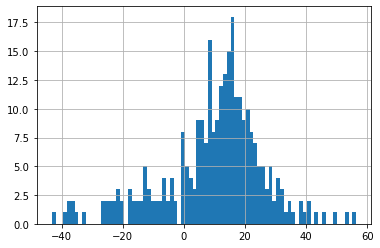

In [19]:
df['S&P_500_FORWARD_1_YEAR_GAIN'].hist(bins=80)

In [20]:
df.shape

(289, 13)

In [21]:
y_classificated = np.where(y>increase,1,np.where(y<=decline,-1,0))

In [22]:
y_classificated

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  0, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [23]:
# Split the targets into training/testing sets
y_classificated_train = y_classificated[:-days_for_test]
y_classificated_test = y_classificated[-days_for_test:]

## Linear regression

In [24]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [25]:
# Train the model using the training sets
regr.fit(X_train, y_train)

LinearRegression()

In [26]:
# Make predictions using the testing set
y_pred = regr.predict(X_test)

In [27]:
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("MSE: %.2f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
r_sqr_test = r2_score(y_test, y_pred)
print("R^2: %.2f" % r_sqr_test)

Coefficients: 
 [-0.10576003  1.13860283 -1.53378081  3.45220235  8.2611764   1.36572186
 -5.43555766 -3.05428106]
MSE: 292.57
R^2: -0.34


In [28]:
regression_result = pd.DataFrame([features, list(regr.coef_)]).T
regression_result.columns = ['Feature','Coefficient']
regression_result.set_index('Feature')

,Coefficient
Feature,
PE_RATIO,-0.10576
Fwd_PE_RATIO,1.138603
5Y_GENERIC,-1.533781
1Y_GENERIC,3.452202
PE_Yield,8.261176
FWD_PE_minus_5Y,1.365722
CPI_YOY,-5.435558
Expected_inflation_5Y,-3.054281


## Linear regression with p-value

In [29]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
est2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     11.03
Date:                Mon, 22 Aug 2022   Prob (F-statistic):           3.52e-13
Time:                        15:29:58   Log-Likelihood:                -982.08
No. Observations:                 241   AIC:                             1982.
Df Residuals:                     232   BIC:                             2014.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -41.8059     45.141     -0.926      0.355    -130.744      47.132
x1            -0.1058      1.559     -0.068      0.946      -3.177       2.966
x2             1.1386      2.066      0.551      0.582      -2.932       5.209
x3            -1.5338      4.810     -0.319      0.750     -11.010       7.943
x4             3.4522      1.566      2.205      0.028       0.368       6.537
x5             8.2612      5.953      1.388      0.167      -3.468      19.990
x6             1.3657      4.701      0.291      0.772      -7.897      10.628
x7            -5.4356      1.016     -5.352      0.000      -7.437      -3.434
x8            -3.0543      2.170     -1.407      0.161      -7.330       1.222
==============================================================================
Omnibus:                       25.748   Durbin-Watson:                   0.174
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.005
Skew:                          -0.793   Prob(JB):                     1.85e-07
Kurtosis:                       3.758   Cond. No.                     1.29e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

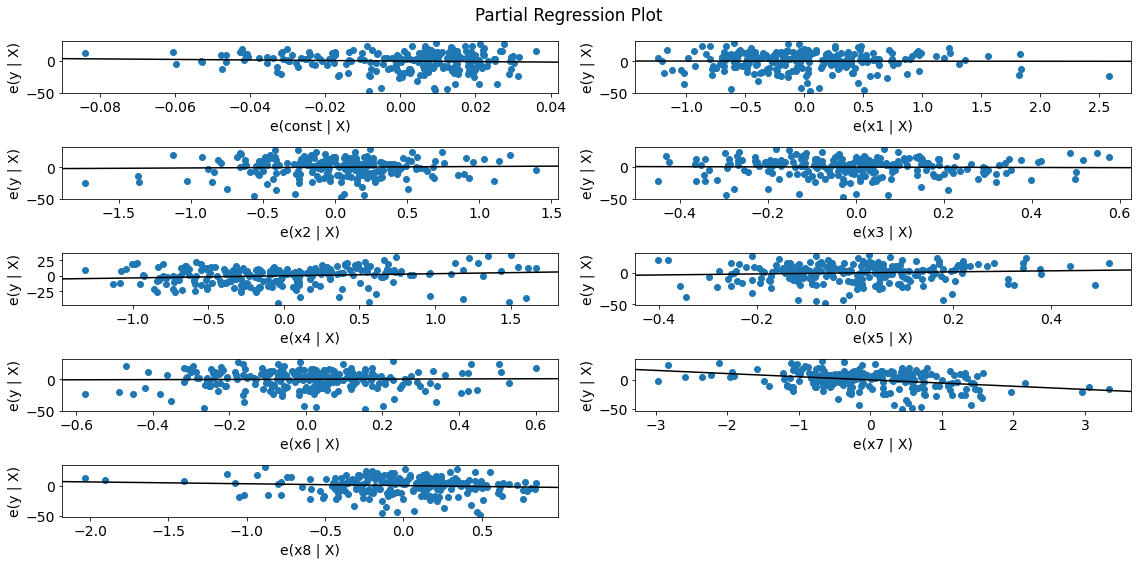

In [30]:
plt.rc("figure", figsize=(16, 8))
plt.rc("font", size=14)

fig = sm.graphics.plot_partregress_grid(est2)
fig.tight_layout(pad=1.0)

* The R^2 of train

In [31]:
y_trained = regr.predict(X_train)
y_trained
r_sqr_train = r2_score(y_train, y_trained)
print("R^2: %.2f" % r_sqr_train)

R^2: 0.28


that means the model is not flexible enough

## Desision tree

In [32]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(random_state=4, max_depth=4, min_samples_leaf=2)
clf = clf.fit(X_train, y_classificated_train)

[Text(495.99999999999994, 391.392, 'X[3] <= 5.63\ngini = 0.371\nsamples = 241\nvalue = [55, 3, 183]'),
 Text(396.79999999999995, 304.416, 'X[3] <= 1.535\ngini = 0.322\nsamples = 228\nvalue = [42, 3, 183]'),
 Text(198.39999999999998, 217.44, 'X[3] <= 0.085\ngini = 0.091\nsamples = 106\nvalue = [4, 1, 101]'),
 Text(99.19999999999999, 130.464, 'gini = 0.5\nsamples = 2\nvalue = [0, 1, 1]'),
 Text(297.59999999999997, 130.464, 'X[3] <= 0.195\ngini = 0.074\nsamples = 104\nvalue = [4, 0, 100]'),
 Text(198.39999999999998, 43.488, 'gini = 0.172\nsamples = 42\nvalue = [4, 0, 38]'),
 Text(396.79999999999995, 43.488, 'gini = 0.0\nsamples = 62\nvalue = [0, 0, 62]'),
 Text(595.1999999999999, 217.44, 'X[1] <= 12.5\ngini = 0.451\nsamples = 122\nvalue = [38, 2, 82]'),
 Text(495.99999999999994, 130.464, 'gini = 0.0\nsamples = 7\nvalue = [7, 0, 0]'),
 Text(694.3999999999999, 130.464, 'X[2] <= 5.05\ngini = 0.419\nsamples = 115\nvalue = [31, 2, 82]'),
 Text(595.1999999999999, 43.488, 'gini = 0.475\nsamples 

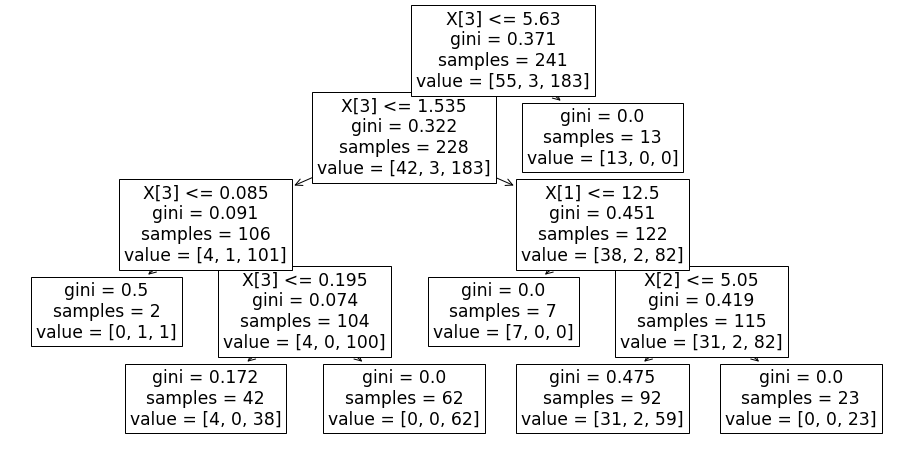

In [33]:
tree.plot_tree(clf)

In [34]:
from sklearn.tree import export_text

In [35]:
r = export_text(clf, feature_names=features)
print(r)

|--- 1Y_GENERIC <= 5.63
|   |--- 1Y_GENERIC <= 1.53
|   |   |--- 1Y_GENERIC <= 0.09
|   |   |   |--- class: 0
|   |   |--- 1Y_GENERIC >  0.09
|   |   |   |--- 1Y_GENERIC <= 0.20
|   |   |   |   |--- class: 1
|   |   |   |--- 1Y_GENERIC >  0.20
|   |   |   |   |--- class: 1
|   |--- 1Y_GENERIC >  1.53
|   |   |--- Fwd_PE_RATIO <= 12.50
|   |   |   |--- class: -1
|   |   |--- Fwd_PE_RATIO >  12.50
|   |   |   |--- 5Y_GENERIC <= 5.05
|   |   |   |   |--- class: 1
|   |   |   |--- 5Y_GENERIC >  5.05
|   |   |   |   |--- class: 1
|--- 1Y_GENERIC >  5.63
|   |--- class: -1



In [36]:
y_pred = clf.predict(X_test)

In [37]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_classificated_test, y_pred))

Accuracy: 0.7916666666666666


In [38]:
precision_tree = metrics.precision_score(y_classificated_test, y_pred, average=None)
print("Precision:", precision_tree)

Precision: [0.         0.14285714 0.90243902]


C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
recall_tree = metrics.recall_score(y_classificated_test, y_pred, average=None)
print("Recall:", recall_tree)

Recall: [0.    0.5   0.925]


In [40]:
y_classificated_test

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1, -1])

In [41]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0])

### Viz the tree

In [42]:
# from sklearn.tree import export_graphviz
# from sklearn.externals.six import StringIO  
# from IPython.display import Image  
# import pydotplus

# dot_data = StringIO()
# export_graphviz(clf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True,feature_names = features,class_names=['3','4','5'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('diabetes.png')
# Image(graph.create_png())

### Grid search for the tree

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [44]:
# hyperparameter tuning
def grid_search():
    param_grid = {
        'max_depth': [2,3,4],
        'min_samples_leaf': [3 , 8 ,10],
        'class_weight': [
                         {-1: 3, 0: 2, 1:3},
                         {-1: 2, 0: 1, 1:2},
                         {-1: 7, 0: 1, 1:5}
                        ]
    }
    
    clf = tree.DecisionTreeClassifier(random_state=4)
    search = RandomizedSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=3)
    search.fit(X_train,y_classificated_train)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [45]:
start = time.time()

grid_search()

end = time.time()
print('execution time in minutes: ', (end - start)/60) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameter (CV score=0.640):
{'min_samples_leaf': 10, 'max_depth': 2, 'class_weight': {-1: 3, 0: 2, 1: 3}}
execution time in minutes:  0.08366516828536988


In [68]:
clf = tree.DecisionTreeClassifier(random_state=4, max_depth=2, min_samples_leaf=10, class_weight={-1: 3, 0: 1, 1: 3})
clf.fit(X_train,y_classificated_train)
y_pred = clf.predict(X_test)
precision_tree = metrics.precision_score(y_classificated_test, y_pred, average=None)
recall_tree = metrics.recall_score(y_classificated_test, y_pred, average=None)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
precision_tree

array([0.        , 0.        , 0.83333333])

In [70]:
recall_tree

array([0., 0., 1.])

## RandomForestClassifier

In [49]:
from sklearn.ensemble import RandomForestClassifier

In [50]:
pipline = Pipeline(steps=[
    ('model', RandomForestClassifier())
])

Possible scorings: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

In [51]:
# hyperparameter tuning
def grid_search():
    param_grid = {
        'model__n_estimators': n_estimators,
        'model__max_features': max_features,
        'model__max_depth': max_depth,
        'model__min_samples_split': min_samples_split,
        'model__min_samples_leaf': min_samples_leaf,
        'model__bootstrap': bootstrap
    }
    global search
    global scoring
    scoring = 'f1_macro'
    search = RandomizedSearchCV(pipline, param_grid, cv=5, n_jobs=-1, verbose=3, scoring=scoring)
    search.fit(X_train,y_classificated_train)

    print("Best parameter (CV score=%0.3f):" % search.best_score_)
    print(search.best_params_)

In [52]:
start = time.time()

grid_search()

end = time.time()
print('execution time in minutes: ', (end - start)/60)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


Best parameter (CV score=0.391):
{'model__n_estimators': 831, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': 6, 'model__bootstrap': False}
execution time in minutes:  0.5429387132326762


In [53]:
optimal_parameters = search.best_params_.copy()
optimal_parameters = pd.DataFrame([optimal_parameters])
optimal_parameters

,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__bootstrap
0,831,10,1,auto,6,False


In [54]:
rf = RandomForestClassifier(n_estimators=optimal_parameters['model__n_estimators'][0],
                            min_samples_split=optimal_parameters['model__min_samples_split'][0],
                            min_samples_leaf=optimal_parameters['model__min_samples_leaf'][0],
                            max_features=optimal_parameters['model__max_features'][0],
                            max_depth=optimal_parameters['model__max_depth'][0],
                            bootstrap=optimal_parameters['model__bootstrap'][0])
rf.fit(X_train,y_classificated_train)

RandomForestClassifier(bootstrap=False, max_depth=6, min_samples_split=10,
                       n_estimators=831)

In [55]:
y_pred = rf.predict(X_test)
precision_rf = metrics.precision_score(y_classificated_test, y_pred, average=None).round(3)
recall_rf = metrics.recall_score(y_classificated_test, y_pred, average=None).round(3)

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [56]:
# X_test

In [57]:
y_pred

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1, -1, -1])

In [58]:
y_classificated_test

array([ 1,  1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  0, -1, -1, -1])

In [59]:
precision_rf

array([1.   , 0.   , 0.889])

In [60]:
recall_rf

array([0.5, 0. , 1. ])

### This month

In [61]:
y_pred_this_month = rf.predict(X_this_month)
y_pred_this_month

array([1])

### Results

In [62]:
rf_results = search.best_params_.copy()
rf_results.update({'days for test' : days_for_test,
                   'Regression R^2 of train' : r_sqr_train,
                   'Regression R^2 of test' : r_sqr_test,
                   'Tree_precision' : precision_tree,
                   'Tree_recall' : recall_tree,
                    'Forest_Scoring' : scoring,
                    'Forest_Precision' : precision_rf,
                   'Forest_Recall' : recall_rf,
                    'Forest_Target' : target,
                    'Range' : (decline, increase),
                     'Forest_y_pred' : y_pred,
                     'Forest_y_test' : y_classificated_test,
                       'features' : features,
                      'A forecast for the next year' : y_pred_this_month})

In [63]:
current_rf_results = pd.DataFrame([rf_results])
current_rf_results

,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__bootstrap,days for test,Regression R^2 of train,Regression R^2 of test,Tree_precision,Tree_recall,Forest_Scoring,Forest_Precision,Forest_Recall,Forest_Target,Range,Forest_y_pred,Forest_y_test,features,A forecast for the next year
0,831,10,1,auto,6,False,48,0.275581,-0.339252,"[0.0, 0.0, 0.8333333333333334]","[0.0, 0.0, 1.0]",f1_macro,"[1.0, 0.0, 0.889]","[0.5, 0.0, 1.0]",S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, -1, -1, 1, 1, 1, 1, 1, 1, 1, 1, 1...","[PE_RATIO, Fwd_PE_RATIO, 5Y_GENERIC, 1Y_GENERI...",[1]


In [64]:
# only one time
# current_rf_results.to_csv('rf_results.csv', index= False)

In [65]:
past_rf_results = pd.read_csv("rf_results.csv")
past_rf_results

,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__bootstrap,days for test,Regression R^2 of train,Regression R^2 of test,Tree_precision,Tree_recall,Forest_Scoring,Forest_Precision,Forest_Recall,Forest_Target,Range,Forest_y_pred,Forest_y_test,features,A forecast for the next year
0,200,10,2,auto,5,False,48,0.275581,-0.339252,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[1. 0. 0.889],[0.5 0. 1. ],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,"['PE_RATIO', 'Fwd_PE_RATIO', '5Y_GENERIC', '1Y...",[1]
1,747,10,1,sqrt,5,True,48,0.093398,-0.636076,[0.22222222 0. 0.84615385],[0.33333333 0. 0.825 ],f1_macro,[0.286 0. 0.854],[0.333 0. 0.875],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['PE_RATIO'],[1]
2,494,2,1,auto,3,False,48,0.075599,-0.609980,[0.21428571 0. 0.88235294],[0.5 0. 0.75],f1_macro,[0.214 0. 0.882],[0.5 0. 0.75],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['Fwd_PE_RATIO'],[1]
3,915,5,1,auto,5,True,48,0.122505,0.175846,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.826],[0. 0. 0.95],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['5Y_GENERIC'],[1]
4,789,2,1,auto,2,True,48,0.109029,0.023948,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.833],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['1Y_GENERIC'],[1]
5,578,10,1,auto,3,False,48,0.104244,-0.624183,[0.33333333 0. 0.87179487],[0.5 0. 0.85],f1_macro,[0.333 0. 0.872],[0.5 0. 0.85],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 -1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['PE_Yield'],[1]
6,831,5,2,auto,5,False,48,0.122573,-0.057850,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.833],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['FWD_PE_minus_5Y'],[1]
7,621,10,2,sqrt,5,False,48,0.042449,0.009978,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0.25 0. 0.841],[0.167 0. 0.925],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['Expected_inflation_5Y'],[1]
8,1000,10,4,sqrt,4,False,48,0.127198,0.034929,[0.3 0. 0.89473684],[0.5 0. 0.85],f1_macro,[1. 0. 0.87],[0.333 0. 1. ],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['CPI_YOY'],[-1]
9,621,2,2,auto,5,True,48,0.275581,-0.339252,[0.14285714 0. 0.65853659],[1. 0. 0.93103448],f1_macro,[0. 0. 0.604],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-10, 10)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 ...,"['PE_RATIO', 'Fwd_PE_RATIO', '5Y_GENERIC', '1Y...",[1]


In [66]:
pd.concat([past_rf_results, current_rf_results], ignore_index=True).to_csv("./rf_results.csv", index= False)

In [67]:
pd.read_csv("rf_results.csv")

,model__n_estimators,model__min_samples_split,model__min_samples_leaf,model__max_features,model__max_depth,model__bootstrap,days for test,Regression R^2 of train,Regression R^2 of test,Tree_precision,Tree_recall,Forest_Scoring,Forest_Precision,Forest_Recall,Forest_Target,Range,Forest_y_pred,Forest_y_test,features,A forecast for the next year
0,200,10,2,auto,5,False,48,0.275581,-0.339252,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[1. 0. 0.889],[0.5 0. 1. ],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,"['PE_RATIO', 'Fwd_PE_RATIO', '5Y_GENERIC', '1Y...",[1]
1,747,10,1,sqrt,5,True,48,0.093398,-0.636076,[0.22222222 0. 0.84615385],[0.33333333 0. 0.825 ],f1_macro,[0.286 0. 0.854],[0.333 0. 0.875],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['PE_RATIO'],[1]
2,494,2,1,auto,3,False,48,0.075599,-0.609980,[0.21428571 0. 0.88235294],[0.5 0. 0.75],f1_macro,[0.214 0. 0.882],[0.5 0. 0.75],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['Fwd_PE_RATIO'],[1]
3,915,5,1,auto,5,True,48,0.122505,0.175846,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.826],[0. 0. 0.95],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 -1 -1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['5Y_GENERIC'],[1]
4,789,2,1,auto,2,True,48,0.109029,0.023948,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.833],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['1Y_GENERIC'],[1]
5,578,10,1,auto,3,False,48,0.104244,-0.624183,[0.33333333 0. 0.87179487],[0.5 0. 0.85],f1_macro,[0.333 0. 0.872],[0.5 0. 0.85],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 -1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['PE_Yield'],[1]
6,831,5,2,auto,5,False,48,0.122573,-0.057850,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0. 0. 0.833],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['FWD_PE_minus_5Y'],[1]
7,621,10,2,sqrt,5,False,48,0.042449,0.009978,[0. 0. 0.83333333],[0. 0. 1.],f1_macro,[0.25 0. 0.841],[0.167 0. 0.925],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['Expected_inflation_5Y'],[1]
8,1000,10,4,sqrt,4,False,48,0.127198,0.034929,[0.3 0. 0.89473684],[0.5 0. 0.85],f1_macro,[1. 0. 0.87],[0.333 0. 1. ],S&P_500_FORWARD_1_YEAR_GAIN,"(-0.1, 1)",[ 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...,[ 1 1 1 1 -1 -1 1 1 1 1 1 1 1 1 1 ...,['CPI_YOY'],[-1]
9,621,2,2,auto,5,True,48,0.275581,-0.339252,[0.14285714 0. 0.65853659],[1. 0. 0.93103448],f1_macro,[0. 0. 0.604],[0. 0. 1.],S&P_500_FORWARD_1_YEAR_GAIN,"(-10, 10)",[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...,[ 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 ...,"['PE_RATIO', 'Fwd_PE_RATIO', '5Y_GENERIC', '1Y...",[1]
